# Využití neuronových sítí

## Zdroj dat

 * Zdrojem dat je soubor `train.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.

# Řešení

In [51]:
!mkdir -p models

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from random import randrange
from tqdm import tqdm

# sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import ParameterGrid

# pytorch
from torch import tensor
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import Generator
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD

%matplotlib inline

Načtu dataset a uložím si názvy tříd do slovníku.

In [53]:
data = pd.read_csv('train.csv')

# item code conversion to name from original MNIST dataset doc
ITEM = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',    
    8 : 'Bag',    
    9 : 'Ankle boot',    
}

## Průzkum dat

In [54]:
display(data.shape)
display(data.head())

(56000, 1025)

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,7
1,4,4,4,4,4,4,5,5,5,6,...,4,4,4,4,4,4,4,4,4,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Zobrazím NULL hodnoty a počet unikátních tříd k predikci.

In [55]:
print('Null values:', data.isna().sum().sum())
print('Unique labels:', len(data['label'].unique()))

Null values: 0
Unique labels: 10


Následující funkce vykreslují buď jeden obrázek nebo vykreslí víc obrázků do mřížky.

In [56]:
def plot_image(img: np.ndarray, label: int = None):
    """ Plot image with optional label """
    
    fig, ax = plt.subplots(figsize = (4, 4))
    ax.axis('off')
    ax.imshow(img.resize(32, 32), cmap = plt.cm.gray)
    
    if label is not None: ax.set_title(ITEM[label])
    
    plt.show()
    
def plot_images(images: np.ndarray, labels: np.ndarray = None, rows: int = 2, cols: int = 8) -> None:
    """ Plot images from given ndarray """
        
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 2, rows * 2))
    axes = axes.ravel()

    for i in range(rows * cols):
        axes[i].axis('off')
        axes[i].imshow(images[i].reshape(32, 32), cmap = plt.cm.gray)
        
        if labels is not None: axes[i].set_title(ITEM[labels[i]])
        
    plt.show()

Rozdělním si data na příznaky a třídy. Následně vykreslím 30 prvních obrázků.

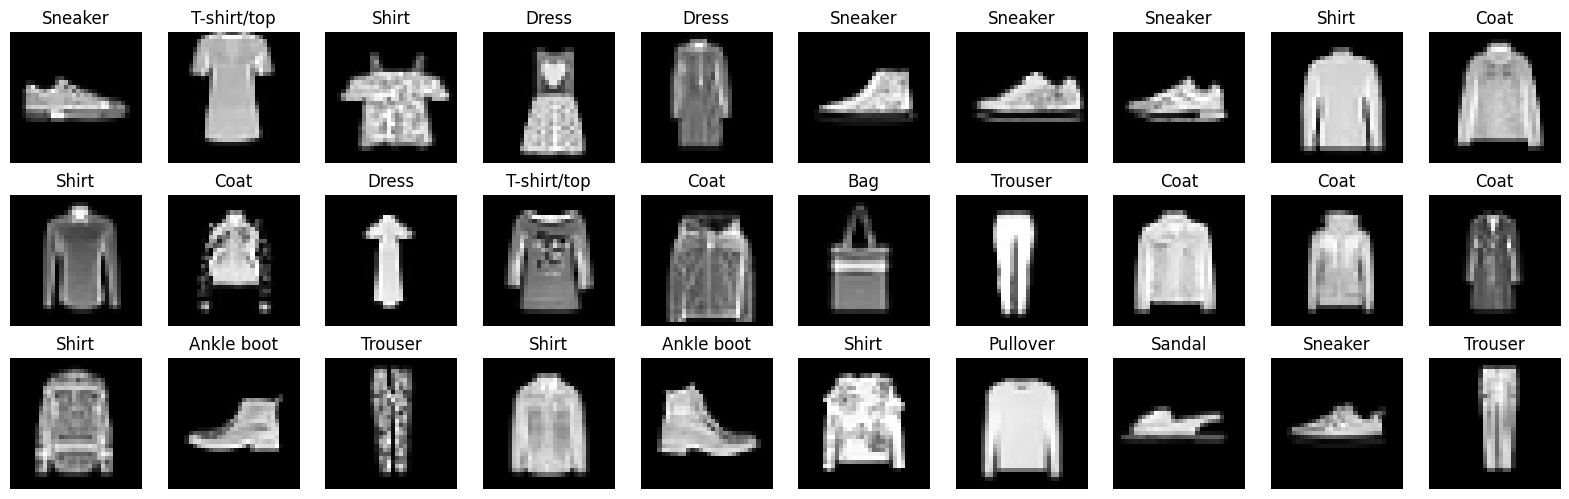

In [67]:
X, y = data.drop(['label'], axis = 1).to_numpy(), data['label'].to_numpy()

plot_images(X, y, 3, 10)

Zobrazím si ještě četnosti jednotlivých kusů oblečení v datasetu.

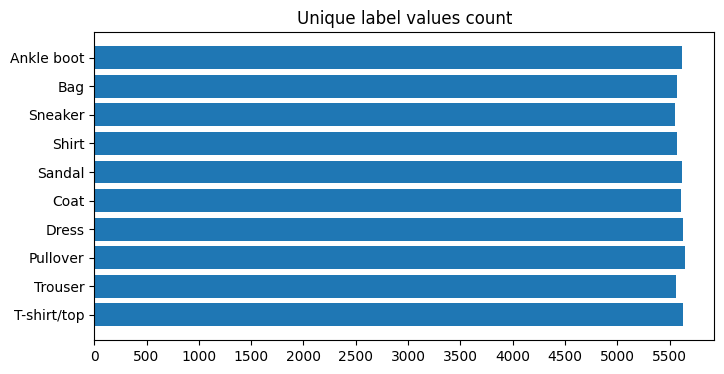

In [60]:
keys, values = np.unique(y, return_counts = True)

fig, ax = plt.subplots(figsize = (8, 4))
ax.barh(keys, values)

ax.set_title('Unique label values count')
ax.set_yticks(np.arange(10), [ITEM[label] for label in keys])
ax.set_xticks(np.arange(0, np.max(values), 500))

plt.show()

V následující buňce vykreslím průměrnou hodnotu pixelu a rozptyl pixelu.

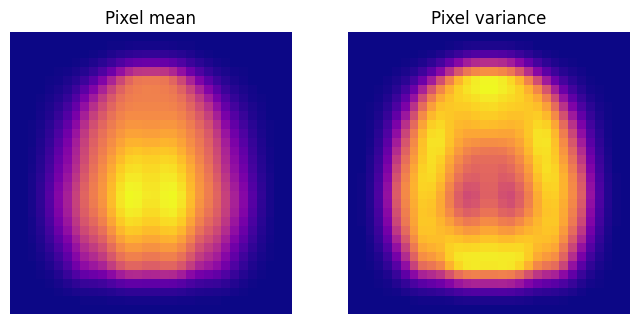

In [35]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))

axes[0].imshow(np.mean(X, axis = 0).reshape(32, 32), cmap = plt.cm.plasma)
axes[0].axis('off')
axes[0].set_title('Pixel mean')

axes[1].imshow(np.var(X, axis = 0).reshape(32, 32), cmap = plt.cm.plasma)
axes[1].axis('off')
axes[1].set_title('Pixel variance')

plt.show()

Můžeme pozorovat, že obrázky se na krajích spíš nenacházejí a nacházejí se spíše uprostřed.

Z grafu rozptylu můžeme vidět, které pixely se často mění.

# Trénování modelu
V této sekci se zaměřím na samotnou tvorbu a trénování modelů.

## Použití GPU
Nejdříve ověřím, zda mohu provádět výpočty pomocí grafické karty. Pokud ano, tak veškeré tensory nastavím na CUDA device.

In [61]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## Rozdělení dat
Rozdělím data na `trénovací`, `validační` a `testovací` pomocí tensor generátoru.

Před tím však převedu data na tenzory a obrazová data převedu na tvar: **(N, Channels, Height, Width)**

In [62]:
SEED = 42
torch.manual_seed(SEED)

# reshape images onto (image count, color channels, height, width) then cast to tosors on DEVICE
X, y = data.drop(['label'], axis = 1).to_numpy(), data['label'].to_numpy()
X, y = tensor(X.reshape(-1, 1, 32, 32), dtype = torch.float, device = DEVICE), tensor(y, dtype = torch.long, device = DEVICE)

print(f"Data shape: {X.shape, y.shape}\n")

train, val, test = random_split(TensorDataset(X, y), [0.7, 0.2, 0.1], Generator())
print(f'train: {len(train)}')
print(f'val:   {len(val)}')
print(f'test:  {len(test)}')

Data shape: (torch.Size([56000, 1, 32, 32]), torch.Size([56000]))

train: 39200
val:   11200
test:  5600


### Normalizace
Připravím si i data normalizovaná hodnotou **255**, jelikož se jedná o maxímální možnou hodnotu pixelu. Tento krok mi veškeré pixely normalizuje na hodnoty z intervalu **[0,1]**.

Úpravu budu aplikovat na celý tenzor.

In [63]:
MAX_PIX = 255
train_norm, val_norm, test_norm = random_split(TensorDataset(X / MAX_PIX, y), [0.7, 0.2, 0.1], Generator())

### Dávkovače dat
V následující buňce si připravím dávkovače dat pro normalizovaná i originální data.

In [64]:
BATCH_SIZE = 64

# original data loaders
train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val, batch_size = BATCH_SIZE * 2, shuffle = False)
test_loader = DataLoader(test, batch_size = BATCH_SIZE * 2, shuffle = False)

# normalized loaders
train_loader_norm = DataLoader(train_norm, batch_size = BATCH_SIZE, shuffle = True)
val_loader_norm = DataLoader(val_norm, batch_size = BATCH_SIZE * 2, shuffle = False)
test_loader_norm = DataLoader(test_norm, batch_size = BATCH_SIZE * 2, shuffle = False)

print(f'train batches: {len(train_loader)}')
print(f'val batches:  {len(val_loader)}')
print(f'test batches:  {len(test_loader)}')

train batches: 613
val batches:   88
test batches:   44


## Generalizace modelu
Pro generalizaci modelu a jednodušší práci při trénování vytvořím třídu `NeuralNetwork` a funkci pro rovnoměrné generování vrstev.

### Třída NeuralNetwork
Jedná se o třídu, která obaluje samotný trénovaný model. Jako taková na vstupu dostává dávkovače a parametry pro regularizaci.

Následně nad touto třídou lze volat metody: `net_train`, `known_predict`, `predict` a další. Generalizace je zajištěna právě metodou `net_train`, která jako parametry dostává **model**, **optimizer** a počet epoch.

Dále třída umí:
- L1, L2 regularizaci
- trénování libovolého modelu (ModuleList optimalizace)
- early stopping s uložením nejlepšího modelu

In [69]:
class NeuralNetwork:
    """ Forward neural network wrapper with training methods """
    
    def __init__(self, train_loader, val_loader, name = 'model', l_reg = { 'L' : None, 'alpha' : 0.1 }, log = True):
        
        self.log = log
        self.name = name
        
        # init data loaders
        self.train = train_loader
        self.val = val_loader
        
        # init layers
        self.layers = nn.ModuleList()
        
        # early stopping params
        self.best_vloss = 10000000.
        self.worse_epochs = 0
        
        # loss function with regularization params
        self.loss_f = CrossEntropyLoss()
        self.l_reg = l_reg
        
    class Net(nn.Module):
        """ Neural network class containing layers and forward func """
        
        def __init__(self, layers):
            super().__init__()
            self.layers = nn.ModuleList(layers)
        
        def forward(self, x):            
            for f in self.layers:
                x = f(x)
            return x
        
        def predict(self, x):
            self.train(False)
            
            with torch.no_grad():
                return self.forward(x)
            
    def save_if_better(self, vloss) -> None:
        """ Saves current model params if has better vloss """
                
        if vloss < self.best_vloss:
            self.best_vloss, self.worse_epochs = vloss, 0
            torch.save(net.state_dict(), f'models/{self.name}.pt')
        else:
            self.worse_epochs += 1
        
    def compute_lreg(self, net) -> float:
        """ Compute loss regularization based on model params """
        
        if self.l_reg['L'] == None: return tensor(0., device = DEVICE)  
    
        if self.l_reg['L'] == 1: return self.l_reg['alpha'] * sum([torch.sum(torch.abs(p)) for p in net.parameters()])
    
        if self.l_reg['L'] == 2: return self.l_reg['alpha'] * sum([torch.sum(torch.square(p)) for p in net.parameters()])
    
    def train_epoch(self, net, opt):
        """ Run one training epoch on given net with given optimizer """
       
        # use all training with progress tracking on log
        train_cum_loss = 0.
        for batch in tqdm(self.train, total = len(self.train), disable = not self.log):
            inputs, labels = batch
                        
            # predict batch labels and compute loss
            opt.zero_grad()
            outputs = net(inputs)

            # compute model loss with regularization
            loss = self.loss_f(outputs, labels) + self.compute_lreg(net)
                
            # backpropagation and weight adjustment
            loss.backward()
            opt.step()
                        
            # calculate epoch loss
            train_cum_loss += loss.item() * inputs.shape[0]
        
        return train_cum_loss / len(train)
        
    def net_train(self, net, opt, epochs: int = 1, stop_epochs = 100000) -> list:
        """ Train NN model with given number of epochs and return vloss"""
                
        train_loss, val_loss, val_acc = [], [], []
        
        # train all epochs
        for epoch in range(epochs):
            if self.log: print(f'EPOCH: {epoch + 1}')
            
            # allow grad tracking and train epoch
            net.train(True)
            avg_loss = self.train_epoch(net, opt)            
            net.train(False)

            # Validation performance
            running_cum_vloss = 0.0
            vcorrect = 0
            
            # measure loss for each validation batch
            for vbatch in self.val:
                vinputs, vlabels = vbatch
                
                # predict and calculate validation loss
                with torch.no_grad():
                    voutputs = net(vinputs)                    
                    vloss = self.loss_f(voutputs, vlabels)
                    
                # count the correctly classified samples
                running_cum_vloss += vloss * vinputs.shape[0]
                vcorrect += (voutputs.argmax(1) == vlabels).float().sum()

            # Get average loss and accuraccy
            avg_vloss = running_cum_vloss / len(val)
            vacc = vcorrect / len(val)
            
            train_loss.append(float(avg_loss))
            val_loss.append(float(avg_vloss))
            val_acc.append(float(vacc))
            
            if self.log: print(f'TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuraccy: {vacc:.3f}')
            
            # save each better model and stop if not improving
            self.save_if_better(avg_vloss)
            if self.worse_epochs >= stop_epochs:
                if self.log: 
                    print('-' * 50)
                    print('EARLY STOPPING')
                break
        
        return train_loss, val_loss, val_acc
            
    def known_predict(self, net, loader):
        """ Predict labels for all batches in loader with its currect labels """
                
        ypred, ytrue = np.array([]), np.array([])
        
        # predict values for each testing batch
        for batch in tqdm(loader, total = len(loader)):
            inputs, labels = batch
            
            # predict category
            with torch.no_grad():
                outputs = net(inputs)
                loss = self.loss_f(outputs, labels)
            
            # append predictions to ytest and ypred arrays
            ytrue, ypred = np.append(ytrue, labels.cpu().numpy()), np.append(ypred, outputs.argmax(1).cpu().numpy())
            
        return ytrue, ypred
    
    def predict(self, net, loader):
        """ Predict labels for images from loader """
        
        ypred = np.array([])
        for inputs in tqdm(loader, total = len(loader)):
            
            # predict category
            with torch.no_grad():
                outputs = net(inputs)
                loss = self.loss_f(outputs, labels)
            
            ypred = np.append(ypred, outputs.argmax(1).cpu().numpy())

### Generování vrstev
Ještě vytvořím funkci, která mi vrátí na základě `vstupní dimenze`, `výstupní dimenze` a `počtu vrstev` plně propojené vrstvy, které na sebe navazují a postupně změnšují svůj počet neuronů.

In [73]:
def generate_layers(input_dim: int, output_dim: int, depth: int = 1, relu: bool = False) -> list:
    """ Generates layers by steps based on params """
    
    if depth == 1: 
        return [nn.Linear(input_dim, output_dim)]
    
    layers = []
    step = (input_dim - output_dim) // (depth)
        
    # generate in / out dimension by step
    for i, x in enumerate(np.arange(output_dim, input_dim, step)[depth - 1::-1]):
        
        # input layer dimension match
        if i == 0:
            layers.append(nn.Linear(input_dim, x))
            if relu: layers.append(nn.ReLU())
            continue

        layers.append(nn.Linear(x + step, x))
        if relu: layers.append(nn.ReLU())
        
    if relu:
        layers.pop()
    
    return layers

generate_layers(25, 5, 4, relu = True)

[Linear(in_features=25, out_features=20, bias=True),
 ReLU(),
 Linear(in_features=20, out_features=15, bias=True),
 ReLU(),
 Linear(in_features=15, out_features=10, bias=True),
 ReLU(),
 Linear(in_features=10, out_features=5, bias=True)]

## Dopředné sítě

### Počet vrstev
U dopředných sítí ze začátku budu zkoumat, jaký je optimální počet vrstev. Proto tedy v následující buňce vždy natrénuji model a uložím jeho `test loss`, `validation loss` a `accuracy`.

Maximální hloubka kterou budu testovat je `10`.

In [76]:
DEPTH = 10
tloss_all, vloss_all, acc_all = [], [], []

# try network width param
for depth in tqdm(np.arange(1, DEPTH + 1)):
    
    # generate layers and params for NN
    layers = [nn.Flatten()] + generate_layers(1024, 10, depth = depth, relu = True)
    net = NeuralNetwork.Net(layers).cuda()
    opt = Adam(net.parameters())
    
    # train neural network and save losses and accuracy
    model = NeuralNetwork(train_loader, val_loader, name = 'forward', log = False)
    tloss, vloss, acc = model.net_train(net, opt, epochs = 20, stop_epochs = 5)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [06:11<00:00, 37.17s/it]


In [79]:
# select best model
accuracies = [np.max(vacc) for vacc in acc_all]
best_forward_idx = np.argmax(accuracies)
forward_tloss, forward_vloss, forward_acc = tloss_all[best_forward_idx], vloss_all[best_forward_idx], acc_all[best_forward_idx]

Vykreslím accuracy, validation loss a test lost pro nejlepší model.

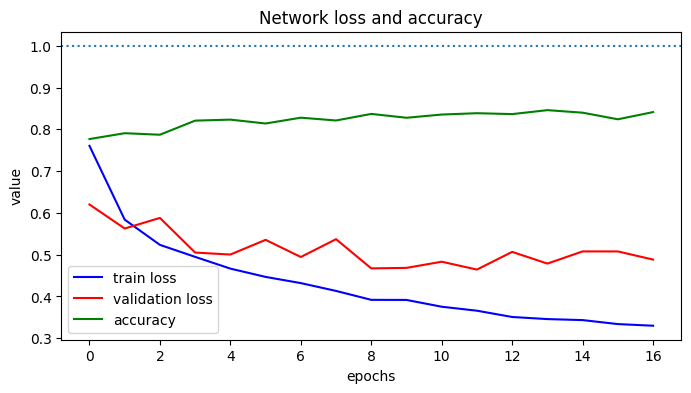

Best width:     6
Best test loss: 0.3298
Best val loss:  0.4642
Best accuracy:  0.8458



[Linear(in_features=1024, out_features=855, bias=True),
 ReLU(),
 Linear(in_features=855, out_features=686, bias=True),
 ReLU(),
 Linear(in_features=686, out_features=517, bias=True),
 ReLU(),
 Linear(in_features=517, out_features=348, bias=True),
 ReLU(),
 Linear(in_features=348, out_features=179, bias=True),
 ReLU(),
 Linear(in_features=179, out_features=10, bias=True)]

In [82]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('Network loss and accuracy')
ax.plot(forward_tloss, 'b-')
ax.plot(forward_vloss, 'r-')
ax.plot(forward_acc, 'g-')
ax.axhline(1, linestyle = ':')
ax.set_ylabel('value')
ax.set_xlabel('epochs')
ax.legend(['train loss', 'validation loss', 'accuracy'])
plt.show()

print(f'Best width:     {best_forward_idx + 1}')
print(f'Best test loss: {np.min(forward_tloss):.4f}')
print(f'Best val loss:  {np.min(forward_vloss):.4f}')
print(f'Best accuracy:  {np.max(forward_acc):.4f}')
print()

display(generate_layers(1024, 10, depth = best_forward_idx + 1, relu = True))

Můžeme vidět, že jsme dosáhli přesnosti `0.84` s použitím sítě se 6 vrstvama.

### Šířka vrstev
Dále mohu zkoumat, jak je přesnost ovlivněna počtem neuronů ve skrytých vrstvách.

Proto ponechám stejnou hloubku sítě a zredukuji počet neuronů ve vrstvě na **32**, **64** a **128**.

In [90]:
layers = [
    nn.Flatten(),
    nn.Linear(1024, 32), nn.ReLU(),
    nn.Linear(32, 32), nn.ReLU(),
    nn.Linear(32, 32), nn.ReLU(),
    nn.Linear(32, 32), nn.ReLU(),
    nn.Linear(32, 32), nn.ReLU(),
    nn.Linear(32, 10)
]

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'forward_32', log = False)
forward_tloss_32, forward_vloss_32, forward_acc_32 = model.net_train(net, opt, epochs = 20)

In [91]:
layers = [
    nn.Flatten(),
    nn.Linear(1024, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 10)
]

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'forward_64', log = False)
forward_tloss_64, forward_vloss_64, forward_acc_64 = model.net_train(net, opt, epochs = 20)

In [92]:
layers = [
    nn.Flatten(),
    nn.Linear(1024, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 10)
]

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'forward_128', log = False)
forward_tloss_128, forward_vloss_128, forward_acc_128 = model.net_train(net, opt, epochs = 20)

#### Porovnání přesností
Porovnám přenosti všech zatím natrénovaných modelů.

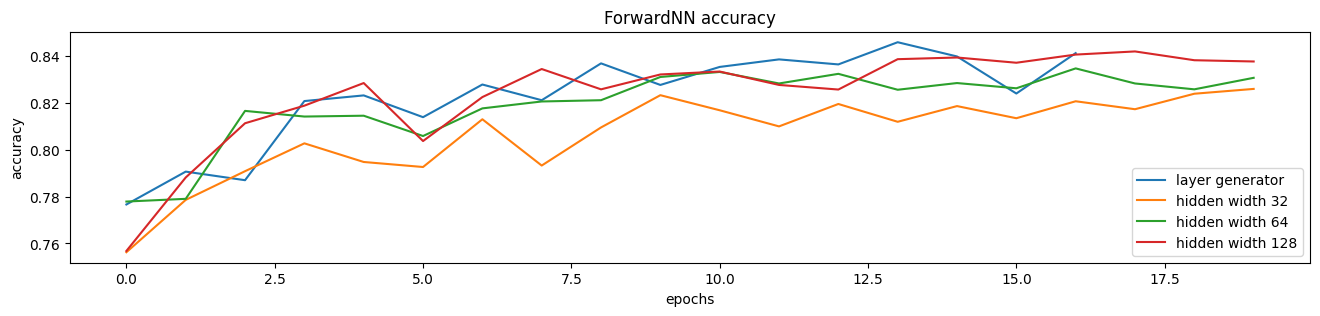

In [93]:
fig, ax = plt.subplots(figsize = (16, 3))

ax.set_title('ForwardNN accuracy')
ax.plot(forward_acc)
ax.plot(forward_acc_32)
ax.plot(forward_acc_64)
ax.plot(forward_acc_128)
ax.set_ylabel('accuracy')
ax.set_xlabel('epochs')
ax.legend(['layer generator', 'hidden width 32', 'hidden width 64', 'hidden width 128'])
plt.show()

Z grafu můžeme vidět, že nejlepší přesnost měl původní model s použitím rovnoměrného generátoru vrstev.

### Normalizovaná data
Vyzkouším opět natrénovat modely pro různé hloubky sítě. Tentokrát ale použiju normalizovaná data.

In [94]:
DEPTH = 10
tloss_all, vloss_all, acc_all = [], [], []

for depth in tqdm(np.arange(1, DEPTH + 1)):
    
    layers = [nn.Flatten()] + generate_layers(1024, 10, depth = depth, relu = True)
    net = NeuralNetwork.Net(layers).cuda()
    opt = Adam(net.parameters())

    tloss, vloss, acc = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'forward_norm', log = False).net_train(net, opt, epochs = 20)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [07:38<00:00, 45.81s/it]


In [95]:
# select best model
forward_norm_idx = np.argmax([np.max(vacc) for vacc in acc_all])
forward_norm_tloss, forward_norm_vloss, forward_norm_acc = tloss_all[forward_norm_idx], vloss_all[forward_norm_idx], acc_all[forward_norm_idx]

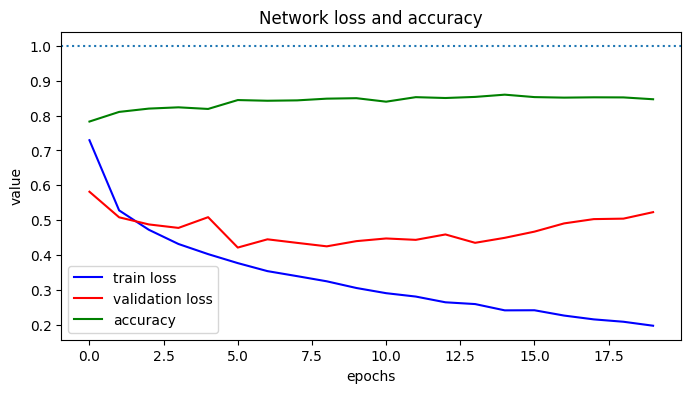

Best width:     4
Best test loss: 0.1981
Best val loss:  0.4219
Best accuracy:  0.8598



[Linear(in_features=1024, out_features=769, bias=True),
 ReLU(),
 Linear(in_features=769, out_features=516, bias=True),
 ReLU(),
 Linear(in_features=516, out_features=263, bias=True),
 ReLU(),
 Linear(in_features=263, out_features=10, bias=True)]

In [96]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('Network loss and accuracy')
ax.plot(forward_norm_tloss, 'b-')
ax.plot(forward_norm_vloss, 'r-')
ax.plot(forward_norm_acc, 'g-')
ax.axhline(1, linestyle = ':')
ax.set_ylabel('value')
ax.set_xlabel('epochs')
ax.legend(['train loss', 'validation loss', 'accuracy'])
plt.show()

print(f'Best width:     {forward_norm_idx + 1}')
print(f'Best test loss: {np.min(forward_norm_tloss):.4f}')
print(f'Best val loss:  {np.min(forward_norm_vloss):.4f}')
print(f'Best accuracy:  {np.max(forward_norm_acc):.4f}')
print()

display(generate_layers(1024, 10, depth = forward_norm_idx + 1, relu = True))

Použitím normalizovaných dat se naše přesnost zlepšila. Zároveň jsme snížili počet vrstev v modelu.

### Optimalizační metody
V této sekci budu testovat, jaký má výběr algoritmu pro optimalizaci vliv na přesnost modelu.

Zároveň budu používat už pouze normalizovaná data a optimální hloubku sítě.

#### ADAM
U tohoto optimalizátoru budu zkoušet různé hodnoty parametru **learning rate**.

In [98]:
tloss_all, vloss_all, acc_all = [], [], []
adam_grid = np.linspace(1e-6, 0.1, 5)

for lr in tqdm(adam_grid):
    
    # used best depth from previos models
    layers = [nn.Flatten()] + generate_layers(1024, 10, depth = 4, relu = True)
    net = NeuralNetwork.Net(layers).cuda()
    opt = Adam(net.parameters(), lr = lr)

    model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'forward_norm_adam', log = False)
    tloss, vloss, acc = model.net_train(net, opt, epochs = 10)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 19.00s/it]


In [99]:
# select best model
adam_accuracy = [np.max(vacc) for vacc in acc_all]
adam_best_idx = np.argmax(adam_accuracy)
forward_norm_adam_tloss, forward_norm_adam_vloss, forward_norm_adam_acc = tloss_all[adam_best_idx], vloss_all[adam_best_idx], acc_all[adam_best_idx]

Vykreslím nejelpší přesnosti modelů v průběhu ladění parametru.

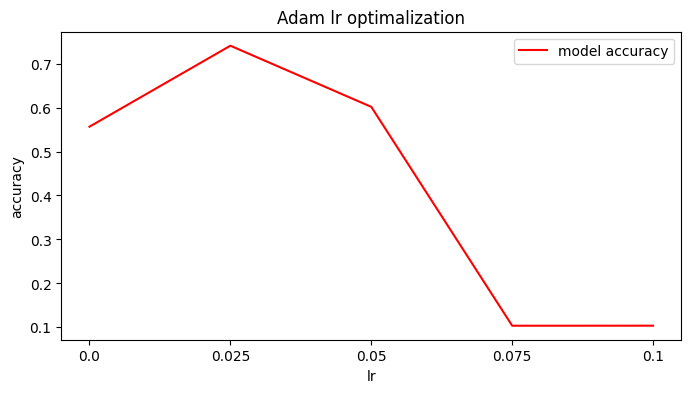

best adam lr:       0.0250
best adam accuracy: 0.7406


In [105]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('Adam lr optimalization')
ax.plot(adam_accuracy, 'r-')

ax.set_ylabel('accuracy')
ax.set_xlabel('lr')
ax.set_xticks(np.arange(5), [round(x, 4) for x in np.linspace(1e-6, 0.1, 5)])
ax.legend(['model accuracy'])
plt.show()

print(f'best adam lr:       {adam_grid[adam_best_idx]:.4f}')
print(f'best adam accuracy: {np.max(forward_norm_adam_acc):.4f}')

Jakožto optimální parametr nám vyšel learning rate `0.025`. I přes to je ale přesnost modelu horší, než při základním nastavení parametrů.

#### SGD
Použiju ještě algoritmus SGD a opět vyzkouším různé parametry.

In [107]:
tloss_all, vloss_all, acc_all = [], [], []

sgd_grid = ParameterGrid({
    'lr' : np.linspace(1e-6, 0.1, 3),
    'momentum' : np.linspace(0.1, 0.9, 4)
})

layers = [nn.Flatten()] + generate_layers(1024, 10, depth = 4, relu = True)

for params in tqdm(sgd_grid):

    net = NeuralNetwork.Net(layers).cuda()
    opt = SGD(net.parameters(), **params)

    model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'forward_norm_sgd', log = False)
    tloss, vloss, acc = model.net_train(net, opt, epochs = 10)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [03:26<00:00, 17.22s/it]


In [108]:
sgd_accuracy = [np.max(vacc) for vacc in acc_all]
best_sgd_idx = np.argmax(sgd_accuracy)
forward_norm_sgd_tloss, forward_norm_sgd_vloss, forward_norm_sgd_acc = tloss_all[best_sgd_idx], vloss_all[best_sgd_idx], acc_all[best_sgd_idx]

I u SGD vykreslím průběh ladění parametrů.

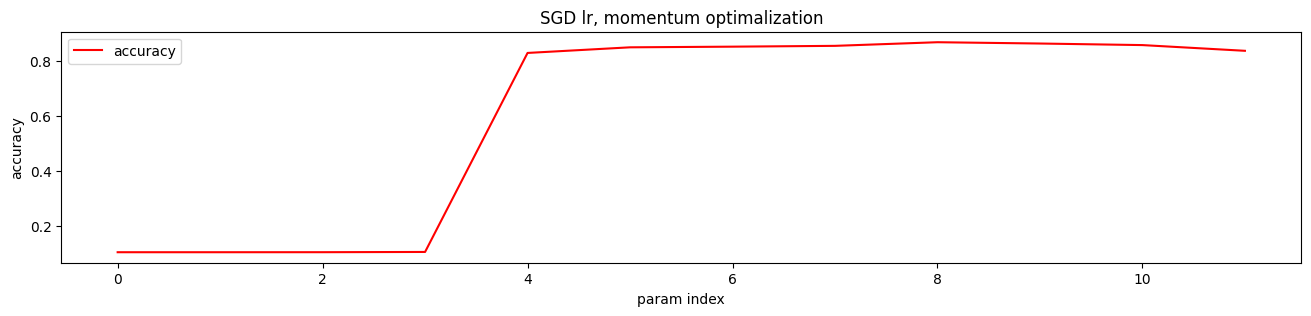

best SGD params: {'momentum': 0.1, 'lr': 0.1}
best accuracy:   0.8688


In [110]:
fig, ax = plt.subplots(figsize = (16, 3))

ax.set_title('SGD lr, momentum optimalization')
ax.plot(sgd_accuracy , 'r-')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['accuracy'])
plt.show()

print(f'best SGD params: {sgd_grid[best_sgd_idx]}')
print(f'best accuracy:   {np.max(forward_norm_sgd_acc):.4f}')

Pomocí ladění parametrů SGD jsme zjistili, že můžeme tímto optimalizačním algoritmem vylepšit přesnost až na `0.86`.

### Regularizace
V této sekci vyzkouším dva druhy regularizace a to `Dropout` A `l1, l2 regularizaci`.

Zároveň použiju nejlepší model s SGD.

#### Dropout
Dropout regularizaci umístím za vstupní vrstvu. Jeho parametr budu taktéž ladit jako hyperparametr.

In [124]:
tloss_all, vloss_all, acc_all = [], [], []

dropout_grid = np.arange(0, 0.6, 0.1)

for drop in tqdm(dropout_grid):
    layers = [
        nn.Flatten(),
        nn.Linear(1024, 769), nn.ReLU(),
        nn.Dropout(p = drop),
        nn.Linear(769, 516), nn.ReLU(),
        nn.Linear(516, 263), nn.ReLU(),
        nn.Linear(263, 10)
    ]
    
    net = NeuralNetwork.Net(layers).cuda()
    opt = SGD(net.parameters(), lr = 0.1, momentum = 0.1)

    model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'forward_norm_dropout', log = False)
    tloss, vloss, acc = model.net_train(net, opt, epochs = 20)

    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:22<00:00, 33.74s/it]


In [125]:
dropout_accuracy = [np.max(vacc) for vacc in acc_all]
best_dropout_idx = np.argmax(dropout_accuracy)
forward_dropout_tloss, forward_dropout_vloss, forward_dropout_acc = tloss_all[best_dropout_idx], vloss_all[best_dropout_idx], acc_all[best_dropout_idx]

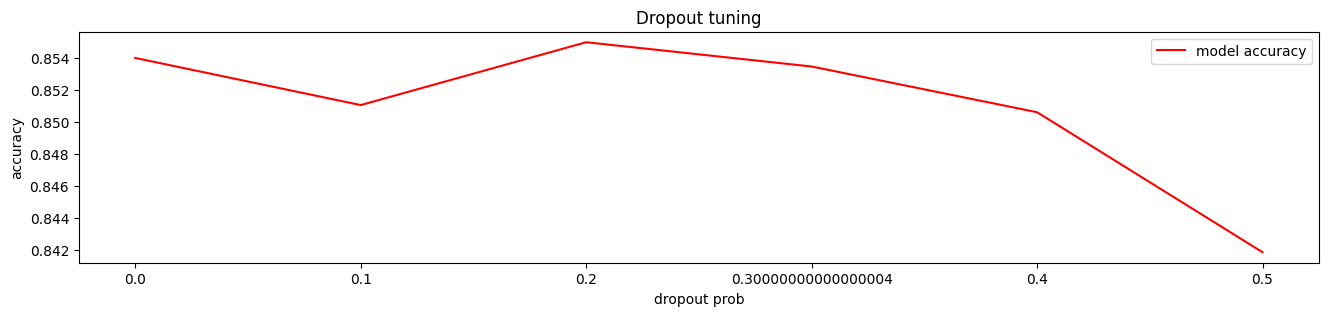

best dropout params: 0.2
best accuracy: 0.8550


In [126]:
fig, ax = plt.subplots(figsize = (16, 3))

ax.set_title('Dropout tuning')
ax.plot(dropout_accuracy , 'r-')
ax.set_ylabel('accuracy')
ax.set_xlabel('dropout prob')
ax.set_xticks(np.arange(6), dropout_grid)
ax.legend(['model accuracy'])
plt.show()

print(f'best dropout params: {dropout_grid[best_dropout_idx]}')
print(f'best accuracy: {np.max(forward_dropout_acc):.4f}')

Model se vlivem dropout regularizace lehce zhoršil.

To může být způsobeno buď nedostatečným množství epoch nebo zvýšením robustnosti modelu vlivem dropout.

#### L1 a L2 regularizace
Třída NeuralNetwork umí regularizovat všechny parametry v síťi pomocí `L1` a `L2` regularizace.

Vyzkouším tedy všechny možnosti regularizace bez použití dropout.

In [128]:
tloss_all, vloss_all, acc_all = [], [], []

reg_grid = ParameterGrid({
    'L' : [1, 2],
    'alpha' : [0.0001, 0.001, 0.1]
})
reg_grid = list(reg_grid) + [{ 'L' : None, 'alpha' : 0}]

layers = [nn.Flatten()] + generate_layers(1024, 10, depth = 4, relu = True)

for params in tqdm(reg_grid):
    
    net = NeuralNetwork.Net(layers).cuda()
    opt = SGD(net.parameters(), lr = 0.1, momentum = 0.1)

    model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'forward_norm_lreg', l_reg = params, log = False)
    tloss, vloss, acc = model.net_train(net, opt, epochs = 20, stop_epochs = 5)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:20<00:00, 28.71s/it]


In [129]:
lreg_accuracy = [np.max(vacc) for vacc in acc_all]
best_lreg_idx = np.argmax(lreg_accuracy)
forward_norm_lreg_tloss, forward_norm_lreg_vloss, forward_norm_lreg_acc = tloss_all[best_lreg_idx], vloss_all[best_lreg_idx], acc_all[best_lreg_idx]

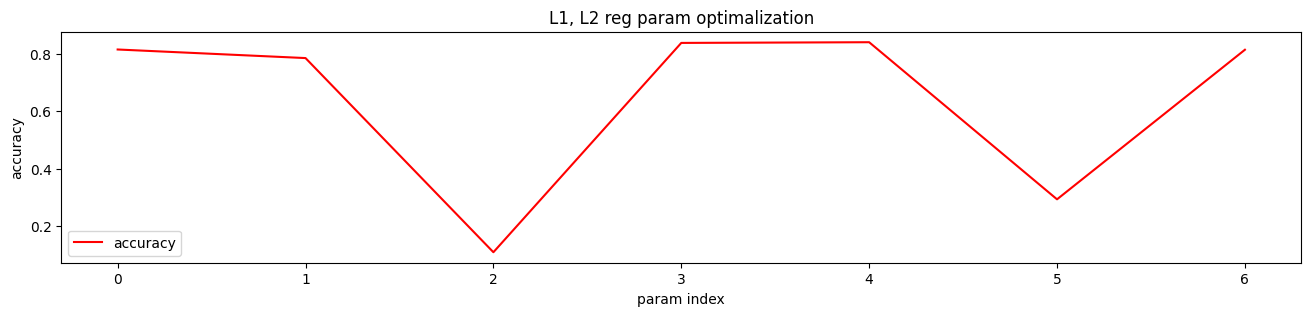

best reg params: {'L': 2, 'alpha': 0.001}
best accuracy:   0.8410


In [130]:
fig, ax = plt.subplots(figsize = (16, 3))

ax.set_title('L1, L2 reg param optimalization')
ax.plot(lreg_accuracy , 'r-')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['accuracy'])
plt.show()

print(f'best reg params: {reg_grid[best_lreg_idx]}')
print(f'best accuracy:   {np.max(forward_norm_lreg_acc):.4f}')

Vlivem L regularizace se model opět zhoršil.

Kdybych tedy měl vybrat nejlepší model bez použití konvoluční sítě, tak bych zatím dosahoval validační přesnosti `0.86`.

## Konvoluční sítě

### Počet vrstev a šířka
V této části budu primárně experimentovat s počtem konvolučních vrstev a jejich parametry.

Následuje konvoluční síť, využívající pouze jednu konvoluci, pooling a 3 plně propojené vrstvy s ReLU.

In [145]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(4, 4),
        
    nn.Flatten(),
] + generate_layers(1568, 10, depth = 3, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'conv1')
conv1_tloss, conv1_vloss, conv1_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 303.89it/s]


TRAIN loss: 1.140, VALIDATION loss: 0.484, accuraccy: 0.819
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 329.81it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.441, accuraccy: 0.830
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 330.95it/s]


TRAIN loss: 0.356, VALIDATION loss: 0.381, accuraccy: 0.860
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 293.65it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.385, accuraccy: 0.857
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 328.78it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.374, accuraccy: 0.869
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 326.75it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.373, accuraccy: 0.873
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 329.27it/s]


TRAIN loss: 0.260, VALIDATION loss: 0.398, accuraccy: 0.864
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 335.73it/s]


TRAIN loss: 0.250, VALIDATION loss: 0.390, accuraccy: 0.868
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 311.71it/s]


TRAIN loss: 0.237, VALIDATION loss: 0.377, accuraccy: 0.873
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 312.60it/s]


TRAIN loss: 0.223, VALIDATION loss: 0.400, accuraccy: 0.877
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 323.82it/s]


TRAIN loss: 0.213, VALIDATION loss: 0.406, accuraccy: 0.867
EPOCH: 12


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 315.03it/s]


TRAIN loss: 0.196, VALIDATION loss: 0.439, accuraccy: 0.870
--------------------------------------------------
EARLY STOPPING


Už teď můžeme pozorovat, že si model s konvoluční vrstvou vede lépe než modely z dopředných síťí.

Zkusím přidat jednu vrstvu navíc.

In [146]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(4, 4),
        
    nn.Flatten(),
] + generate_layers(1568, 10, depth = 4, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'conv2')
conv2_tloss, conv2_vloss, conv2_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 274.91it/s]


TRAIN loss: 0.789, VALIDATION loss: 0.459, accuraccy: 0.827
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 259.08it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.385, accuraccy: 0.857
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 279.53it/s]


TRAIN loss: 0.366, VALIDATION loss: 0.397, accuraccy: 0.856
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 283.47it/s]


TRAIN loss: 0.334, VALIDATION loss: 0.361, accuraccy: 0.868
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 275.21it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.371, accuraccy: 0.863
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 266.81it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.361, accuraccy: 0.872
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 275.26it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.353, accuraccy: 0.879
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 282.74it/s]


TRAIN loss: 0.253, VALIDATION loss: 0.375, accuraccy: 0.871
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 281.75it/s]


TRAIN loss: 0.237, VALIDATION loss: 0.372, accuraccy: 0.873
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 274.49it/s]


TRAIN loss: 0.226, VALIDATION loss: 0.383, accuraccy: 0.874
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 272.15it/s]


TRAIN loss: 0.212, VALIDATION loss: 0.393, accuraccy: 0.875
EPOCH: 12


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 283.88it/s]


TRAIN loss: 0.204, VALIDATION loss: 0.391, accuraccy: 0.874
EPOCH: 13


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 289.85it/s]


TRAIN loss: 0.186, VALIDATION loss: 0.449, accuraccy: 0.871
--------------------------------------------------
EARLY STOPPING


Vyzkouším přidat další konvoluční vrstvu. Tím bych měl značně snížit počet výstupních hodnot ve skytých vrstvách. 

Zároveň budu experimentovat s počtem 3 a 4 následujících vrstev.

In [149]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
        
    nn.Flatten(),
] + generate_layers(1152, 10, depth = 3, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'conv3')
conv3_tloss, conv3_vloss, conv3_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 295.94it/s]


TRAIN loss: 0.666, VALIDATION loss: 0.459, accuraccy: 0.831
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 308.90it/s]


TRAIN loss: 0.408, VALIDATION loss: 0.405, accuraccy: 0.851
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 282.95it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.391, accuraccy: 0.856
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 307.35it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.377, accuraccy: 0.864
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 310.21it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.375, accuraccy: 0.869
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 299.06it/s]


TRAIN loss: 0.246, VALIDATION loss: 0.443, accuraccy: 0.858
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 288.86it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.397, accuraccy: 0.871
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 298.75it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.422, accuraccy: 0.870
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 311.63it/s]


TRAIN loss: 0.183, VALIDATION loss: 0.407, accuraccy: 0.873
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 309.02it/s]


TRAIN loss: 0.169, VALIDATION loss: 0.469, accuraccy: 0.865
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:01<00:00, 306.56it/s]


TRAIN loss: 0.149, VALIDATION loss: 0.486, accuraccy: 0.871
--------------------------------------------------
EARLY STOPPING


In [150]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
        
    nn.Flatten(),
] + generate_layers(1152, 10, depth = 4, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'conv4')
conv4_tloss, conv4_vloss, conv4_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 262.88it/s]


TRAIN loss: 0.614, VALIDATION loss: 0.432, accuraccy: 0.838
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 254.39it/s]


TRAIN loss: 0.390, VALIDATION loss: 0.389, accuraccy: 0.852
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 267.93it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.363, accuraccy: 0.868
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 268.83it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.349, accuraccy: 0.874
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 268.93it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.362, accuraccy: 0.869
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 251.81it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.362, accuraccy: 0.873
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 270.70it/s]


TRAIN loss: 0.224, VALIDATION loss: 0.390, accuraccy: 0.876
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 254.17it/s]


TRAIN loss: 0.199, VALIDATION loss: 0.400, accuraccy: 0.863
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 264.07it/s]


TRAIN loss: 0.175, VALIDATION loss: 0.450, accuraccy: 0.873
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 262.55it/s]


TRAIN loss: 0.166, VALIDATION loss: 0.449, accuraccy: 0.877
--------------------------------------------------
EARLY STOPPING


Zkusím ještě upravit pooling druhé vrstvy tak, aby plně propojené vrstvy pracovali s méně příznaky.

In [151]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    nn.Flatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader, val_loader, name = 'conv3')
conv5_tloss, conv5_vloss, conv5_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 296.33it/s]


TRAIN loss: 0.634, VALIDATION loss: 0.461, accuraccy: 0.826
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 264.19it/s]


TRAIN loss: 0.433, VALIDATION loss: 0.407, accuraccy: 0.853
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 292.97it/s]


TRAIN loss: 0.373, VALIDATION loss: 0.387, accuraccy: 0.862
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 271.64it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.377, accuraccy: 0.868
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 250.09it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.371, accuraccy: 0.869
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 286.22it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.369, accuraccy: 0.869
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 292.38it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.365, accuraccy: 0.873
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 279.11it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.349, accuraccy: 0.876
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 272.01it/s]


TRAIN loss: 0.257, VALIDATION loss: 0.352, accuraccy: 0.876
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 284.47it/s]


TRAIN loss: 0.245, VALIDATION loss: 0.337, accuraccy: 0.882
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 285.47it/s]


TRAIN loss: 0.236, VALIDATION loss: 0.360, accuraccy: 0.883
EPOCH: 12


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 279.26it/s]


TRAIN loss: 0.229, VALIDATION loss: 0.348, accuraccy: 0.882
EPOCH: 13


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 296.20it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.360, accuraccy: 0.883
EPOCH: 14


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 280.02it/s]


TRAIN loss: 0.208, VALIDATION loss: 0.377, accuraccy: 0.879
EPOCH: 15


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 283.12it/s]


TRAIN loss: 0.200, VALIDATION loss: 0.372, accuraccy: 0.882
EPOCH: 16


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 276.47it/s]


TRAIN loss: 0.196, VALIDATION loss: 0.375, accuraccy: 0.885
--------------------------------------------------
EARLY STOPPING


Pro tyto 3 modely vykreslím grafy porovnávající jejich hodnoty validační ztrátové funkce a přesnost v průběhu trénování. 

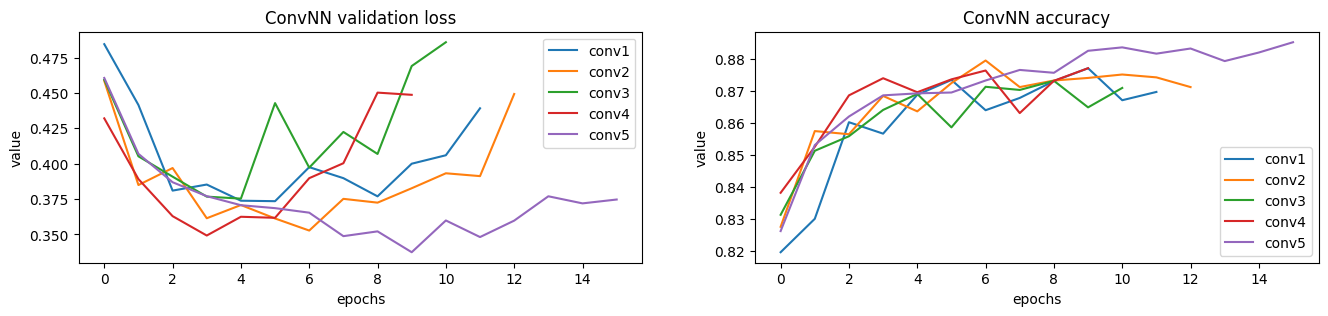

best conv number:     5
best validation loss: 0.3374
best accuracy:        0.8851


In [158]:
# get best conv by argmax
conv_model_acc = [conv1_acc, conv2_acc, conv3_acc, conv4_acc, conv5_acc]
conv_model_vloss = [conv1_vloss, conv2_vloss, conv3_vloss, conv4_vloss, conv5_vloss]
best_conv = np.argmax([np.max(acc) for acc in conv_model_acc])

fig, axes = plt.subplots(1, 2, figsize = (16, 3))

axes[0].set_title('ConvNN validation loss')
for loss in conv_model_vloss:
    axes[0].plot(loss)

axes[0].set_ylabel('value')
axes[0].set_xlabel('epochs')
axes[0].legend([f'conv{x}' for x in range(1, len(conv_model_acc) + 1)])

axes[1].set_title('ConvNN accuracy')
for acc in conv_model_acc:
    axes[1].plot(acc)
    
axes[1].set_ylabel('value')
axes[1].set_xlabel('epochs')
axes[1].legend([f'conv{x}' for x in range(1, len(conv_model_acc) + 1)])
plt.show()

print(f'best conv number:     {best_conv + 1}')
print(f'best validation loss: {np.min(conv_model_vloss[best_conv]):.4f}')
print(f'best accuracy:        {np.max(conv_model_acc[best_conv]):.4f}')

Nejlépe si vedl poslední model se dvěmi konv. vrstvami.

### Normalizovaná data
Nyní tedy vezmu doposud nejlepší nalezenou konvoluční síť a vyzkouším ji natrénovat s pomocí normalizovaných dat.

In [160]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    nn.Flatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'conv_norm')
conv_norm_tloss, conv_norm_vloss, conv_norm_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 244.83it/s]


TRAIN loss: 0.851, VALIDATION loss: 0.573, accuraccy: 0.782
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 300.50it/s]


TRAIN loss: 0.541, VALIDATION loss: 0.472, accuraccy: 0.825
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 298.02it/s]


TRAIN loss: 0.438, VALIDATION loss: 0.405, accuraccy: 0.849
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 286.73it/s]


TRAIN loss: 0.380, VALIDATION loss: 0.354, accuraccy: 0.870
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 294.43it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.343, accuraccy: 0.870
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 300.66it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.349, accuraccy: 0.870
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 302.00it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.356, accuraccy: 0.868
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 301.46it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.334, accuraccy: 0.881
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 282.23it/s]


TRAIN loss: 0.263, VALIDATION loss: 0.298, accuraccy: 0.889
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 298.27it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.310, accuraccy: 0.886
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 279.68it/s]


TRAIN loss: 0.238, VALIDATION loss: 0.319, accuraccy: 0.888
EPOCH: 12


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 277.01it/s]


TRAIN loss: 0.228, VALIDATION loss: 0.309, accuraccy: 0.890
EPOCH: 13


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 275.63it/s]


TRAIN loss: 0.216, VALIDATION loss: 0.308, accuraccy: 0.891
EPOCH: 14


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 299.57it/s]


TRAIN loss: 0.207, VALIDATION loss: 0.333, accuraccy: 0.882
EPOCH: 15


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 295.69it/s]


TRAIN loss: 0.200, VALIDATION loss: 0.329, accuraccy: 0.886
--------------------------------------------------
EARLY STOPPING


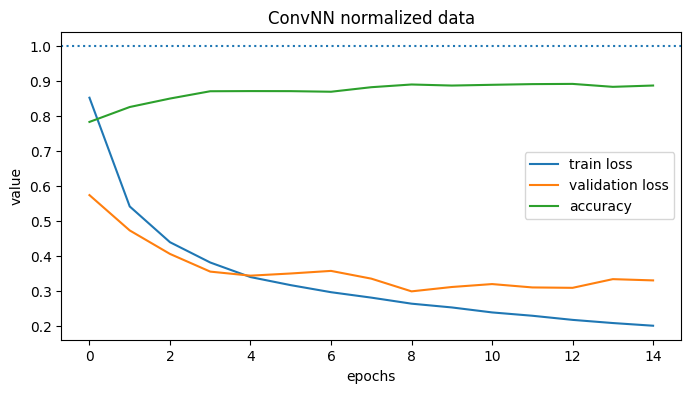

Best train loss:       0.1998
Best validation loss:  0.2980
Best accuracy:         0.8909


In [161]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('ConvNN normalized data')
ax.plot(conv_norm_tloss)
ax.plot(conv_norm_vloss)
ax.plot(conv_norm_acc)
ax.axhline(1, linestyle = ':')
ax.set_ylabel('value')
ax.set_xlabel('epochs')
ax.legend(['train loss', 'validation loss', 'accuracy'])
plt.show()

print(f'Best train loss:       {np.min(conv_norm_tloss):.4f}')
print(f'Best validation loss:  {np.min(conv_norm_vloss):.4f}')
print(f'Best accuracy:         {np.max(conv_norm_acc):.4f}')

Z validation loss a přenosti můžeme usoudit, že normalizovaná data pomáhají k lepší predikci. Budu tedy používat pouze normalizovaná data.

Přesnost modelu jsme vylepšili na `0.89`.

### Optimalizační metody
V základu jsem modely trénoval pomocí optimalizačního algorimtu Adam. V této sekci opět vyzkouším i SGD.

#### ADAM
Stejně jako u dopředných síťí vyzkouším hyperparametr learning rate.

In [166]:
tloss_all, vloss_all, acc_all = [], [], []

grid_adam = np.linspace(1e-9, 0.1, 5)
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    nn.Flatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

for lr in tqdm(grid_adam):

    net = NeuralNetwork.Net(layers).cuda()
    opt = Adam(net.parameters(), lr = lr)

    model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'conv_norm_adam', log = False)
    tloss, vloss, acc =model.net_train(net, opt, epochs = 10)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:52<00:00, 22.52s/it]


In [167]:
adam_accuracy = [np.max(vacc) for vacc in acc_all]
best_adam_idx = np.argmax(adam_accuracy)
conv_norm_adam_tloss, conv_norm_adam_vloss, conv_norm_adam_acc = tloss_all[best_adam_idx], vloss_all[best_adam_idx], acc_all[best_adam_idx]

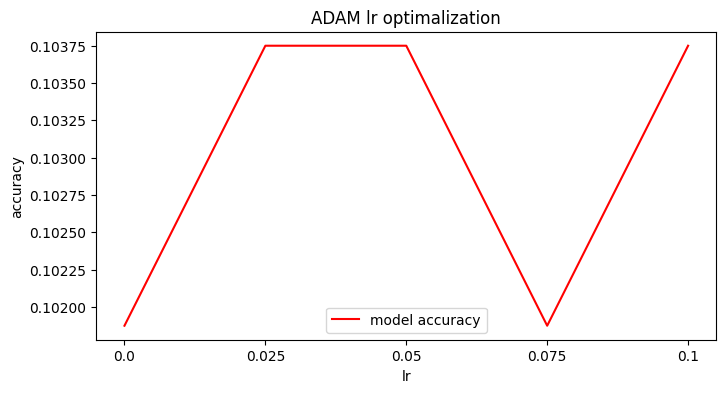

best adam lr: 0.02500000075
best adam accuracy: 0.7406


In [168]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('ADAM lr optimalization')
ax.plot(adam_accuracy, 'r-')

ax.set_ylabel('accuracy')
ax.set_xlabel('lr')
ax.set_xticks(np.arange(5), [round(x, 4) for x in grid_adam])
ax.legend(['model accuracy'])
plt.show()

print(f'best adam lr: {grid_adam[best_adam_idx]}')
print(f'best adam accuracy: {np.max(forward_norm_adam_acc):.4f}')

Přesnost se lehce zhoršila. Ještě vyzkouším SGD a případě budu používat Adam se základními parametry.

#### SGD
Taktéž vyzkouším zda změna algoritmu na SGD opět zlepší přenost modelu.

In [334]:
tloss_all, vloss_all, acc_all = [], [], []

sgd_grid = ParameterGrid({
    'lr' : np.linspace(1e-6, 0.1, 3),
    'momentum' : np.linspace(0.1, 0.9, 4)
})

layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    nn.Flatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

for params in tqdm(sgd_grid):

    net = NeuralNetwork.Net(layers).cuda()
    opt = SGD(net.parameters(), **params)

    tloss, vloss, acc = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'conv_norm_sgd', log = False).net_train(net, opt, epochs = 10)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [03:52<00:00, 19.40s/it]


In [169]:
sgd_accuracy = [np.max(vacc) for vacc in acc_all]
best_sgd_idx = np.argmax(sgd_accuracy)
conv_norm_sgd_tloss, conv_norm_sgd_vloss, conv_norm_sgd_acc = tloss_all[best_sgd_idx], vloss_all[best_sgd_idx], acc_all[best_sgd_idx]

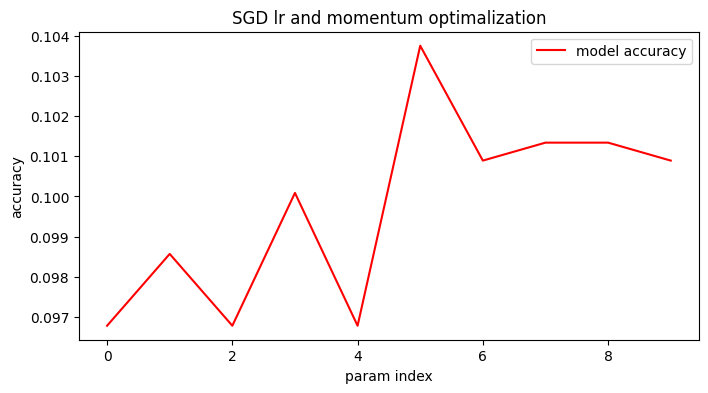

best SGD params:          {'momentum': 0.3666666666666667, 'lr': 1e-06}
best SGD accuracy:        0.1037


In [170]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('SGD lr and momentum optimalization')
ax.plot(conv_norm_sgd_acc, 'r-')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['model accuracy'])
plt.show()

print(f'best SGD params:          {sgd_grid[best_sgd_idx]}')
print(f'best SGD accuracy:        {np.max(conv_norm_sgd_acc):.4f}')

Z grafu a hodnot je vidět, že nám SGD extrémně zhoršíl přesnost. 

Budu nadále tedy používat Adam se základními parametry.

### Regularizace
Opět budu regularizovat model pomocí dropout a L1 nebo L2 regularizace.

#### Dropout
Tentokrát nebudu ladit hodnotu parametru. Přidám tedy Dropout2d s hodnotou 0.2 za první konvoluční vrstvu.

In [179]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    nn.Flatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'conv_norm_dropout')
conv_norm_dropout_tloss, conv_norm_dropout_vloss, conv_norm_dropout_acc = model.net_train(net, opt, epochs = 25, stop_epochs = 6)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 264.77it/s]


TRAIN loss: 0.900, VALIDATION loss: 0.628, accuraccy: 0.765
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 261.54it/s]


TRAIN loss: 0.550, VALIDATION loss: 0.497, accuraccy: 0.808
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 259.99it/s]


TRAIN loss: 0.462, VALIDATION loss: 0.442, accuraccy: 0.833
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 278.20it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.372, accuraccy: 0.862
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 282.14it/s]


TRAIN loss: 0.372, VALIDATION loss: 0.369, accuraccy: 0.863
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 260.47it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.367, accuraccy: 0.865
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 279.88it/s]


TRAIN loss: 0.337, VALIDATION loss: 0.340, accuraccy: 0.874
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 287.01it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.338, accuraccy: 0.874
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 281.34it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.323, accuraccy: 0.881
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 282.21it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.321, accuraccy: 0.881
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 270.23it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.330, accuraccy: 0.878
EPOCH: 12


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 225.02it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.311, accuraccy: 0.887
EPOCH: 13


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 209.68it/s]


TRAIN loss: 0.270, VALIDATION loss: 0.298, accuraccy: 0.888
EPOCH: 14


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 263.36it/s]


TRAIN loss: 0.255, VALIDATION loss: 0.305, accuraccy: 0.887
EPOCH: 15


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 292.07it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.302, accuraccy: 0.887
EPOCH: 16


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 290.96it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.301, accuraccy: 0.892
EPOCH: 17


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 260.24it/s]


TRAIN loss: 0.235, VALIDATION loss: 0.307, accuraccy: 0.886
EPOCH: 18


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 270.10it/s]


TRAIN loss: 0.228, VALIDATION loss: 0.319, accuraccy: 0.885
EPOCH: 19


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:02<00:00, 277.54it/s]


TRAIN loss: 0.223, VALIDATION loss: 0.316, accuraccy: 0.887
--------------------------------------------------
EARLY STOPPING


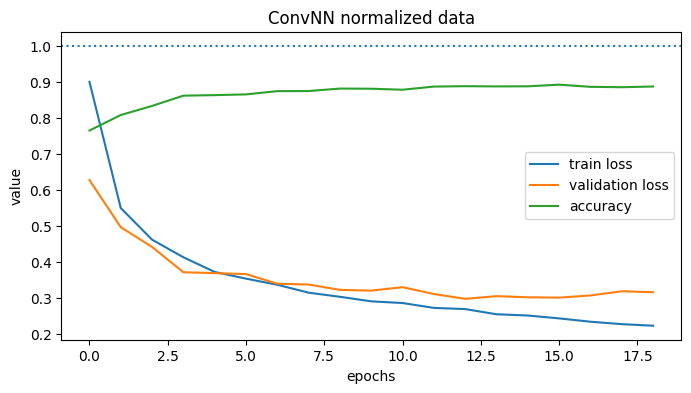

Best train loss:       0.2234
Best validation loss:  0.2980
Best accuracy:         0.8920


In [180]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('ConvNN normalized data')
ax.plot(conv_norm_dropout_tloss)
ax.plot(conv_norm_dropout_vloss)
ax.plot(conv_norm_dropout_acc)
ax.axhline(1, linestyle = ':')
ax.set_ylabel('value')
ax.set_xlabel('epochs')
ax.legend(['train loss', 'validation loss', 'accuracy'])
plt.show()

print(f'Best train loss:       {np.min(conv_norm_dropout_tloss):.4f}')
print(f'Best validation loss:  {np.min(conv_norm_dropout_vloss):.4f}')
print(f'Best accuracy:         {np.max(conv_norm_dropout_acc):.4f}')

#### L1 a L2 regularizace
Opět vyzkouším nějaké parametry regularizace na doposud nejlepší konvoluční model.

Součástí trénování bude i model bez regularizace.

In [181]:
tloss_all, vloss_all, acc_all = [], [], []

reg_grid = ParameterGrid({
    'L' : [1, 2],
    'alpha' : [1e-5, 1e-3, 1e-1]
})
reg_grid = list(reg_grid) + [{ 'L' : None, 'alpha' : 0}]

layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    npredictlatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

for params in tqdm(reg_grid):
    
    net = NeuralNetwork.Net(layers).cuda()
    opt = Adam(net.parameters())
    tloss, vloss, acc = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'conv_norm_lreg', l_reg = params, log = False).net_train(net, opt, epochs = 20, stop_epochs = 5)
    
    tloss_all.append(tloss)
    vloss_all.append(vloss)
    acc_all.append(acc)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:25<00:00, 55.09s/it]


In [184]:
lreg_accuracy = [np.max(vacc) for vacc in acc_all]
best_lreg_idx = np.argmax(lreg_accuracy)
conv_norm_lreg_tloss, conv_norm_lreg_vloss, conv_norm_lreg_acc = tloss_all[best_lreg_idx], vloss_all[best_lreg_idx], acc_all[best_lreg_idx]

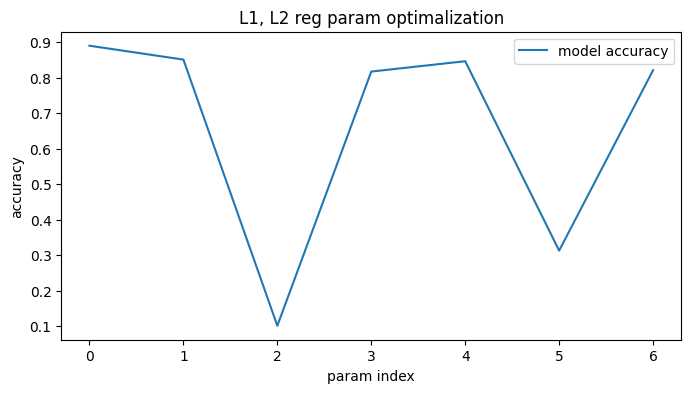

best reg params: {'L': 1, 'alpha': 1e-05}
best accuracy:   0.8905


In [185]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('L1, L2 reg param optimalization')
ax.plot(lreg_accuracy)
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['model accuracy'])
plt.show()

print(f'best reg params: {reg_grid[best_lreg_idx]}')
print(f'best accuracy:   {np.max(conv_norm_lreg_acc):.4f}')

Regularizace lehce snížila přesnost, ale z důvodu robustnosti modelu ji nechám i ve finálním modelu.

## Finální model
Jakožto finální model tedy vyberu konvoluční síť s dvěmi konvolučními vrstvami, dropout vrstvou a 4 plně propojenými vrstvami s ReLU. Zároveň aplikuji L1 regularizaci.

In [189]:
layers = [
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.2),
    
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(6, 2),
        
    nn.Flatten(),
] + generate_layers(512, 10, depth = 4, relu = True)

net = NeuralNetwork.Net(layers).cuda()
opt = Adam(net.parameters())

model = NeuralNetwork(train_loader_norm, val_loader_norm, name = 'conv_norm_fin', l_reg = {'L' : 1, 'alpha' : 1e-5})
conv_fin_tloss, conv_fin_vloss, conv_fin_acc = model.net_train(net, opt, epochs = 50, stop_epochs = 8)

EPOCH: 1


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 179.78it/s]


TRAIN loss: 0.905, VALIDATION loss: 0.658, accuraccy: 0.734
EPOCH: 2


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 191.70it/s]


TRAIN loss: 0.614, VALIDATION loss: 0.505, accuraccy: 0.812
EPOCH: 3


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 194.09it/s]


TRAIN loss: 0.537, VALIDATION loss: 0.439, accuraccy: 0.841
EPOCH: 4


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 189.63it/s]


TRAIN loss: 0.483, VALIDATION loss: 0.391, accuraccy: 0.861
EPOCH: 5


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 179.84it/s]


TRAIN loss: 0.451, VALIDATION loss: 0.358, accuraccy: 0.867
EPOCH: 6


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 179.43it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.362, accuraccy: 0.868
EPOCH: 7


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 186.21it/s]


TRAIN loss: 0.410, VALIDATION loss: 0.337, accuraccy: 0.876
EPOCH: 8


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 181.28it/s]


TRAIN loss: 0.392, VALIDATION loss: 0.347, accuraccy: 0.873
EPOCH: 9


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 179.44it/s]


TRAIN loss: 0.377, VALIDATION loss: 0.320, accuraccy: 0.884
EPOCH: 10


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 185.31it/s]


TRAIN loss: 0.369, VALIDATION loss: 0.347, accuraccy: 0.875
EPOCH: 11


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 183.56it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.313, accuraccy: 0.886
EPOCH: 12


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 177.49it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.310, accuraccy: 0.886
EPOCH: 13


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 187.87it/s]


TRAIN loss: 0.344, VALIDATION loss: 0.310, accuraccy: 0.888
EPOCH: 14


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 184.43it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.306, accuraccy: 0.886
EPOCH: 15


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 178.76it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.318, accuraccy: 0.885
EPOCH: 16


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 187.98it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.323, accuraccy: 0.882
EPOCH: 17


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 190.68it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.314, accuraccy: 0.885
EPOCH: 18


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 183.23it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.310, accuraccy: 0.888
EPOCH: 19


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 189.64it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.300, accuraccy: 0.890
EPOCH: 20


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 185.20it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.294, accuraccy: 0.892
EPOCH: 21


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 179.88it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.305, accuraccy: 0.892
EPOCH: 22


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 187.95it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.294, accuraccy: 0.894
EPOCH: 23


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 184.75it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.296, accuraccy: 0.894
EPOCH: 24


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 179.85it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.300, accuraccy: 0.895
EPOCH: 25


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 182.47it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.298, accuraccy: 0.892
EPOCH: 26


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 185.99it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.305, accuraccy: 0.889
EPOCH: 27


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 181.12it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.297, accuraccy: 0.893
EPOCH: 28


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:03<00:00, 189.06it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.331, accuraccy: 0.883
--------------------------------------------------
EARLY STOPPING


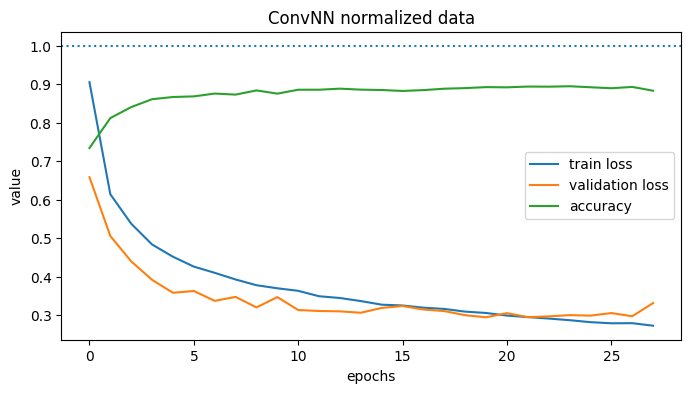

Best train loss:       0.2722
Best validation loss:  0.2940
Best accuracy:         0.8946


In [190]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.set_title('ConvNN normalized data')
ax.plot(conv_fin_tloss)
ax.plot(conv_fin_vloss)
ax.plot(conv_fin_acc)
ax.axhline(1, linestyle = ':')
ax.set_ylabel('value')
ax.set_xlabel('epochs')
ax.legend(['train loss', 'validation loss', 'accuracy'])
plt.show()

print(f'Best train loss:       {np.min(conv_fin_tloss):.4f}')
print(f'Best validation loss:  {np.min(conv_fin_vloss):.4f}')
print(f'Best accuracy:         {np.max(conv_fin_acc):.4f}')

Náš model dosahuje nejlepší validační přesnosti a to `0.89`.

Vykreslím ještě matici záměn a očekávanou přesnost na testovacích datech.

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 357.17it/s]


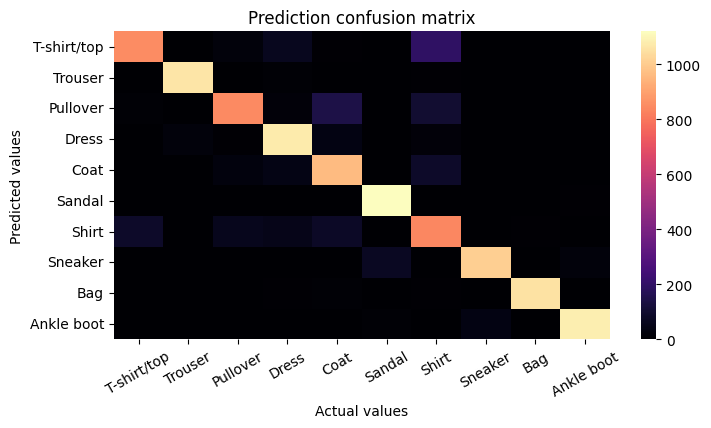

train accuracy:      0.926
validation accuracy: 0.883
test accuracy:       0.890


In [191]:
ytrue_train, ypred_train = model.known_predict(net, train_loader_norm)
ytrue_val, ypred_val = model.known_predict(net, val_loader_norm)
ytrue_test, ypred_test = model.known_predict(net, test_loader_norm)

fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(confusion_matrix(ytrue_val, ypred_val), cmap=plt.cm.magma, ax = ax)

ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')
ax.set_xticklabels([ITEM[i] for i in np.arange(10)], rotation = 30)
ax.set_yticklabels([ITEM[i] for i in np.arange(10)], rotation = 0)

ax.set_title('Prediction confusion matrix')
plt.show()

print(f'train accuracy:      {accuracy_score(ytrue_train, ypred_train):.3f}')
print(f'validation accuracy: {accuracy_score(ytrue_val, ypred_val):.3f}')
print(f'test accuracy:       {accuracy_score(ytrue_test, ypred_test):.3f}')

Na datech, které model ještě neviděl mohu předpokládat přesnost okolo `89%`.